Demographics
====

Demographic type plots

In [1]:
import os

%load_ext autoreload
%autoreload 2

img_dir = "outputs/imgs/demographics/"
if not os.path.exists(img_dir):
    os.makedirs(img_dir)

In [2]:
"""
Read the data

"""

import pandas as pd

from analysis_utils import clean

df = clean.cleaned_survey()

# Find only the people who took part in the smartwatch study
keep = (df["smart1_7to9"] == 1) | (df["smart1_10to17"] == 1)
df = df[keep]

len(df)

82

                count     sex
respondent_sex               
2.0                52  Female
1.0                30    Male


,count,sex
respondent_sex,,
2.0,52,Female
1.0,30,Male


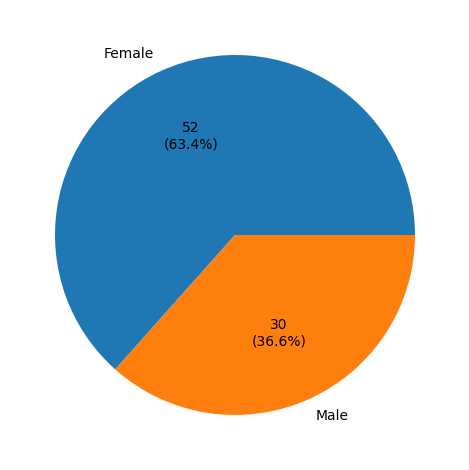

In [3]:
"""
Sex pie chart

"""

import matplotlib.pyplot as plt

sexes = pd.DataFrame(df["respondent_sex"].value_counts())

# 1 for Male 2 for Female
sexes["sex"] = ["Female" if i - 1 else "Male" for i in sexes.index]
print(sexes)


def autopct(val):
    return f"{round(val * len(df) / 100)}\n({val:.1f}%)"


fig, axis = plt.subplots()
axis.pie(
    sexes["count"],
    labels=sexes["sex"],
    autopct=autopct,
)
fig.tight_layout()
fig.savefig(f"{img_dir}/sex_pie.png")

sexes

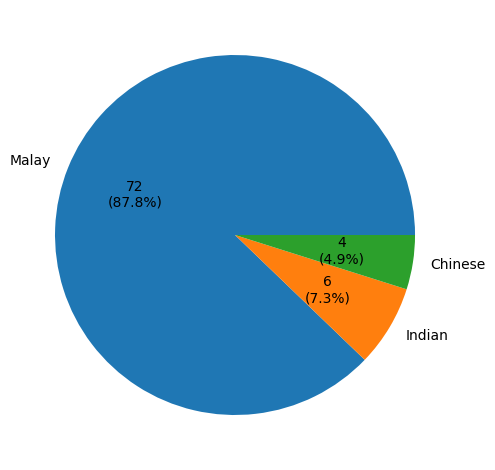

In [4]:
"""
Ethnicity pie chart

"""

ethnicities = df["respondent_ethnicity"].value_counts()

fig, axis = plt.subplots()
ethnicity_codes= {
    1: "Malay",
    2: "Indian",
    3: "Chinese",
    5: "Other",
    8: "Orang Asli",
    -8: "Don't Know",
    -9: "Refused to Answer",
}
axis.pie(
    ethnicities,
    labels=[ethnicity_codes[i] for i in ethnicities.index],
    autopct=autopct,
)
fig.tight_layout()
fig.savefig(f"{img_dir}/ethnicity_pie.png")

7 0
8 1
9 3
10 7
11 4
12 8
13 8
14 10
15 10
16 14
17 16
18 1


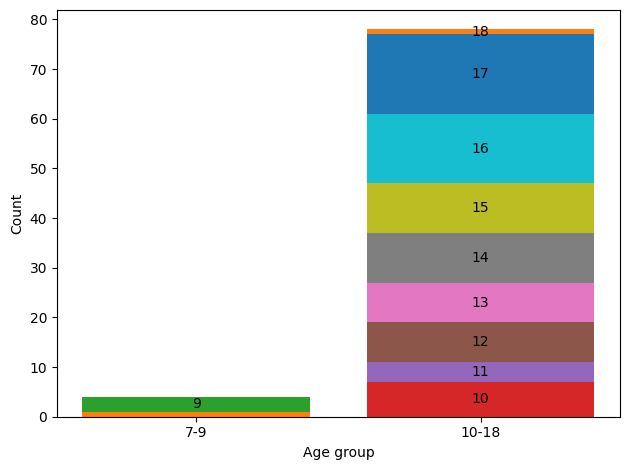

In [5]:
"""
Age histogram

"""

# Stacked bar plot
fig, ax = plt.subplots()

bottom = 0
for age in range(7, 10):
    count = (df["age_dob"] == age).sum()
    ax.bar(0, count, bottom=bottom)
    if count > 2:
        ax.text(0, bottom + count / 2, age, ha="center", va="center")
    bottom += count
    print(age, count)

bottom = 0
for age in range(10, 19):
    count = (df["age_dob"] == age).sum()
    ax.bar(1, count, bottom=bottom)
    ax.text(1, bottom + count / 2, age, ha="center", va="center")
    bottom += count
    print(age, count)

ax.set_xticks((0, 1), ("7-9", "10-18"))

ax.set_ylabel("Count")
ax.set_xlabel("Age group")

fig.tight_layout()
fig.savefig(f"{img_dir}/age_hist.png")

In [6]:
import pandas as pd

# Data
gender_data = {
    "Category": ["Gender", "Gender"],
    "Subcategory": ["Female", "Male"],
    "Count": [52, 30]
}

ethnicity_data = {
    "Category": ["Ethnicity", "Ethnicity", "Ethnicity"],
    "Subcategory": ["Malay", "Chinese", "Indian"],
    "Count": [72, 4, 6]
}

age_data = {
    "Category": ["Age"] * 12,
    "Subcategory": [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18],
    "Count": [0, 1, 3, 7, 4, 8, 8, 10, 10, 14, 16, 1]
}

# Create DataFrames
gender_df = pd.DataFrame(gender_data)
ethnicity_df = pd.DataFrame(ethnicity_data)
age_df = pd.DataFrame(age_data)

# Combine all data into a single DataFrame
combined_data = pd.concat([gender_df, ethnicity_df, age_df])

# Set multi-index
combined_data.set_index(["Category", "Subcategory"], inplace=True)

# Display the combined table
print(combined_data)

                       Count
Category  Subcategory       
Gender    Female          52
          Male            30
Ethnicity Malay           72
          Chinese          4
          Indian           6
Age       7                0
          8                1
          9                3
          10               7
          11               4
          12               8
          13               8
          14              10
          15              10
          16              14
          17              16
          18               1


In [7]:
"""
Number of participants per date with Ramadan indicated

"""
from analysis_utils import read

# Find when each participant started the study
feasibility = read.smartwatch_feasibility()
date_df = df.merge(
    feasibility[["actualdateofdistribution1st", "residents_id"]], on="residents_id"
)

# Keep only people who took part in the smartwatch study
keep = (date_df["smart1_7to9"] == 1) | (date_df["smart1_10to17"] == 1)
date_df = date_df[keep]


# Find the overall start and end dates
study_length = pd.Timedelta(days=8)
first, last = (
    date_df["actualdateofdistribution1st"].min().date(),
    date_df["actualdateofdistribution1st"].max().date() + study_length,
)
days = pd.date_range(first, last, freq="1d")

n_active_participants = []
for day in days:
    n_active = 0
    # Check how many participants were active (start date within 7 days of this day)
    for _, row in date_df.iterrows():
        end_date = row["actualdateofdistribution1st"] + study_length
        if row["actualdateofdistribution1st"] <= day < end_date:
            n_active += 1

    n_active_participants.append(n_active)

# Check that all the entries sum up to 82 (participants) * days
assert sum(n_active_participants) == 82 * study_length.days

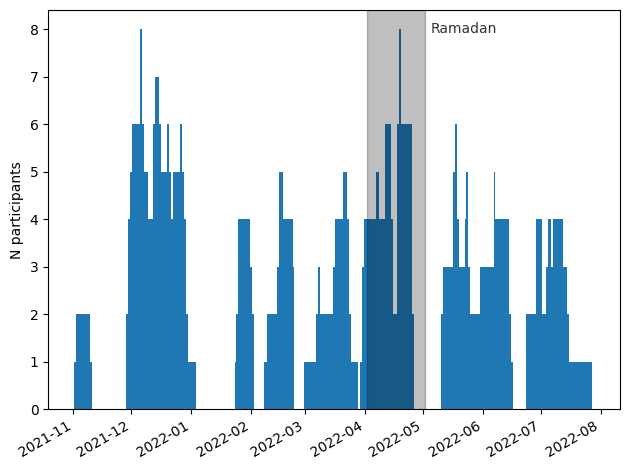

In [8]:
"""
Plot the number of participants per day as a histogram

"""

from analysis_utils import clean, plotting

# Convert the days to bins centred on each day
bins = days - pd.Timedelta(hours=12)
bins = bins.append(pd.DatetimeIndex([pd.to_datetime(last) + pd.Timedelta(hours=12)]))

fig, axis = plt.subplots()

axis.stairs(n_active_participants, bins, fill=True)

plotting.shade_ramadan(axis)
_, ramadan = clean.ramadan_2022()
axis.text(
    ramadan + pd.Timedelta(days=3),
    8,
    "Ramadan",
    ha="left",
    va="center",
    color="black",
    alpha=0.8,
)

axis.set_ylabel("N participants")

fig.autofmt_xdate()
fig.tight_layout()
fig.savefig(f"{img_dir}/participants_per_day.png")

In [17]:
"""
Find how many were active during Ramadan

"""
ramadan_start, ramadan_end = clean.ramadan_2022()
date_df["actualdateofdistribution1st"]
is_in_ramadan = (date_df["actualdateofdistribution1st"] >= ramadan_start) & (date_df["actualdateofdistribution1st"] <= ramadan_end)
is_in_ramadan.sum()
ramadan_start, ramadan_end


(Timestamp('2022-04-02 00:00:00'), Timestamp('2022-05-02 00:00:00'))